Objective is to train a Quantum Classical Hybrid neural network to predict House Price for Boston Housing data.

Created by :- Prateek Jain for Thesis for Masters in Quantum Computing at Universidad Politécnica De Madrid

Install required Libraries

In [ ]:
!pip install keras-metrics --quiet

In [ ]:
!pip install pennylane --quiet

In [ ]:
!pip install pennylane-sf --quiet

In [ ]:
!pip install seaborn --quiet

In [ ]:
!pip install sklearn --quiet

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pennylane as qml
import tensorflow as tf
import numpy as np
import pandas as pd

import keras_metrics
import matplotlib.pyplot as plt
from IPython.display import clear_output

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from pennylane.templates.layers import CVNeuralNetLayers
from pennylane.init import cvqnn_layers_all
from pennylane.optimize import GradientDescentOptimizer

Download the dataset from Keras datasets and split it into Test Train datasets respectively.

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data(test_split=0.3, seed=85)

65536/57026 [==================================] - 0s 0us/step


* This dataset is taken from the StatLib library which is maintained at Carnegie Mellon University.

* Samples contain 13 attributes of houses at different locations around the Boston suburbs in the late 1970s. Target is the median price value of the houses (in k$).

* The data has total **506 samples and 13 features**.

### Boston Housing Features

    1. CRIM      per capita crime rate by town
    2. ZN        proportion of residential land zoned for lots over 
                 25,000 sq.ft.
    3. INDUS     proportion of non-retail business acres per town
    4. CHAS      Charles River dummy variable (= 1 if tract bounds 
                 river; 0 otherwise)
    5. NOX       nitric oxides concentration (parts per 10 million)
    6. RM        average number of rooms per dwelling
    7. AGE       proportion of owner-occupied units built prior to 1940
    8. DIS       weighted distances to five Boston employment centres
    9. RAD       index of accessibility to radial highways
    10. TAX      full-value property-tax rate per 10,000
    11. PTRATIO  pupil-teacher ratio by town
    12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks 
                 by town
    13. LSTAT    % lower status of the population
    
    Target Value - Y labels
    14. MEDV     Median value of owner-occupied homes in $1000's
    
    http://lib.stat.cmu.edu/datasets/boston

### lets put the data into pandas dataframe to print the formatted data for reference


In [ ]:
cols = ["CRIM","ZN","INDUS","CHAS","NOX","RM","AGE",'DIS','RAD', 'TAX','PTRATIO','B','LSTAT']
X_traindf = pd.DataFrame(x_train, columns = cols)
X_traindf['MEDV'] = y_train
X_traindf.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.95577,0.0,8.14,0.0,0.538,6.047,88.8,4.4534,4.0,307.0,21.0,306.38,17.28,14.8
1,0.79041,0.0,9.90,0.0,0.544,6.122,52.8,2.6403,4.0,304.0,18.4,396.90,5.98,22.1
2,0.13262,0.0,8.56,0.0,0.520,5.851,96.7,2.1069,5.0,384.0,20.9,394.05,16.47,19.5
3,0.15098,0.0,10.01,0.0,0.547,6.021,82.6,2.7474,6.0,432.0,17.8,394.51,10.30,19.2
4,0.04379,80.0,3.37,0.0,0.398,5.787,31.1,6.6115,4.0,337.0,16.1,396.90,10.24,19.4


Here we can see How each feature is correlated to the target variable MEDV

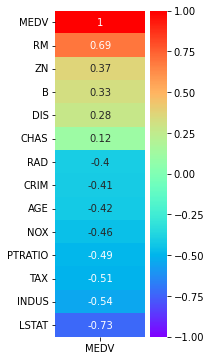

In [ ]:
import seaborn as sns 
top_features = X_traindf.corr()[['MEDV']].sort_values(by=['MEDV'],ascending=False).head(30)
plt.figure(figsize=(2,6))
sns.heatmap(top_features,cmap='rainbow',annot=True,annot_kws={"size": 10},vmin=-1)

From Above we see that 

**RM:** For a higher RM, one would expect to observe a higher MEDV.

- This is because more rooms would imply more space, thereby costing more.

**LSTAT:** For a higher LSTAT, one would expect to observe a lower MEDV.

- Generaly an area with more "lower class" citizens would lower demand, hence lower prices.

**PTRATIO:** For a higher LSTAT, one would expect to observe a lower MEDV.

- This is because there would be a lower teacher-to-student ratio resulting in less attention dedicated to each student that may impair their performance in school. The prices of houses around public schools are generally lower than those around private schools. Hence one would expect a lower price given a high student-to-teacher ratio due to a lower demand for houses in such areas.

### Scale the features

We will standardize our data by scaling it and removing the mean and variance to address the problem of the data being on different scales. We will use StandardScaler from Scikit Learn to scale the data

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

### PCA

Now we will reduce number of features to number of qubits desired using Principle component analysis from scikit


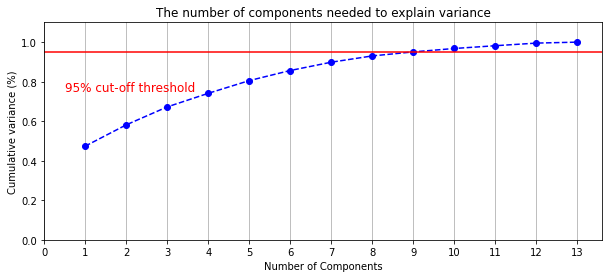

In [ ]:
from sklearn.decomposition import PCA

pca = PCA().fit(x_train)

plt.rcParams["figure.figsize"] = (10,4)

fig, ax = plt.subplots()
xi = np.arange(1, len(x_train[0])+1, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, len(x_train[0])+1, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.75, '95% cut-off threshold', color = 'red', fontsize=12)

ax.grid(axis='x')
plt.show()

Here we can see that to get atleast 95% of variance explained we need 9 principal components which will also be the number of Qubits we will require for our Quantum Circuit.


In [ ]:
pca = PCA(n_components = 0.95) # for 95% variance explained
pca.fit(x_train)

x_train = pca.transform(x_train)
x_test = pca.transform(x_test)

### Declare Variables & Hyperparameters

In [ ]:
n_features = 9  # define the number of features to be used determined by PCA as number of qubits 
learning_rate=.08
epochs=25
batch_size=5
shots = 1024

### 1. Quantum Classical Hybrid Neural Network

* Now here we create Qubits to represent features and encode using **AngleEmbedding** Template from pennylane. First we create device, then qnode. In qnode we define a quantum function , where in we take inputs & weights as parameters.

* **StronglyEntanglingLayers** allows us to train Quantum Layer using parameters. Keras will create weights and pass it to the qnode and in turn to StronglyEntanglingLayers.

* A single StronglyEntanglingLayers can have multiple repeated layers. Each layer has three trainiable parameters that can be adjusted. The shape of the weights is therefore [layers, no of qubits, 3]. 

* For predicted output we use Dense Layer with linear activation.

* We use the **SGD** Optimizer

* Since we have a linear regression problem selected loss type is **mean squared error**. MSE: The mean square error (MSE) squares the difference before summing them all instead of using the absolute value. 

* After trying a variety of Quantum devices & Simulators available we selected the **default.qubit.tf** device which is based on tensorflow and is faster than default and many other devices

* The **quantum_model** is built by sandwiching the quantum Neural Network layer between two Classical Input & output layers

In [ ]:
layers = 2

my_bucket = f"amazon-braket-52e22b396243" # the name of the bucket
my_prefix = "rigetti" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

s3_folder = (my_bucket, my_prefix)

device_arn_rigetti = "arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-1"

device_arn_ionq = "arn:aws:braket:::device/qpu/ionq/ionQdevice"

device_arn_sv1 = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"

dev_rigetti = qml.device("braket.aws.qubit",
    device_arn=device_arn_rigetti,
    wires=n_features,
    s3_destination_folder=s3_folder,
    parallel=True,
    shots=shots
)


#dev = qml.device("default.qubit", wires=n_features, shots=shots)
dev = qml.device("default.qubit.tf", wires=n_features, shots=shots) # This device works much faster than the default.qubit device
#dev = qml.device('qiskit.ibmq', wires=n_features, backend='ibmq_qasm_simulator', ibmqx_token="XXX")

@qml.qnode(dev_rigetti)
def qnn_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires = range(n_features))
    qml.templates.StronglyEntanglingLayers(weights, wires = range(n_features))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_features)]

weight_shapes = {"weights": (layers, n_features,3)}

qlayer = qml.qnn.KerasLayer(qnn_circuit, weight_shapes, output_dim = n_features)
clayer_in = tf.keras.layers.Dense(n_features, activation = 'relu')
clayer_out = tf.keras.layers.Dense(n_features, activation = "linear")

quantum_model = tf.keras.models.Sequential([clayer_in,qlayer,clayer_out])

optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate)

quantum_model.compile(optimizer, loss='mse', metrics=["mae", "acc"])

Train the model

In [ ]:
quantum_history = quantum_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)
clear_output()

y_pred_q = quantum_model.predict(x_test)
y_pred_q = np.mean(y_pred_q, axis=1)
print('Done')

Done


### 2. Classical Neural Network 

Here we create a simple **Classical** Neural Network using tensorflow and Keras, the architecture of the NN contains these layers similar to our earlier QNN-Hybrid approach the input layer has number of features as inputs and the output layer has one output

In [ ]:
classical_model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=n_features),                  
        tf.keras.layers.Dense(64, activation=tf.nn.relu),
        tf.keras.layers.Dense(64, activation=tf.nn.softmax),
        tf.keras.layers.Dense(1)])
classical_model.compile(loss='mse', optimizer=optimizer, metrics=["mae", "acc"])

Train the model

In [ ]:
classical_history = classical_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)

y_pred_c = classical_model.predict(x_test)
print('Done')

Done


### 3. QNN - CVNeuralNetLayers (Photonic)

* Architecturally this QNN is very similar to the NN defined in section 3.2 earlier, the key difference is that this QNN is build with Photonic Quantum Computer by Xanadu as basis.
* First, we create a photonic QPU device using the photonic QML library Strawberryfields
* Then we create the qnode (quantum circuit) by using the DisplacementEmbedding for feature encoding and CVNeuralNetLayers as the photonic quantum neural network layer for continuous variables.
* DisplacementEmbedding Encodes N features into the displacement amplitudes r or phases ϕ of M modes/qubits, where N ≤ M 
* CVNeuralNetLayers is A sequence of layers of a continuous-variable quantum neural network, as specified in arXiv:1806.06871. The layer consists of interferometers, displacement and squeezing gates mimicking the linear transformation of a neural network in the x-basis of the quantum system, and uses a Kerr gate to introduce a ‘quantum’ nonlinearity.
* Similar to earlier QNN the photonic quantum classical hybrid neural network model has the quantum circuit layer sandwiched between the input and output classical NN layers [clayer_in, qlayer, clayer_out]
* Here to the qml.qnn.KerasLayer is used to act as a wrapper for QNode to convert it into a layer that’s compatible with TensorFlow and Keras. The gradient for the quantum part of the network is supplied by the QNode using the strawberryfields.fock device and is calculated by finite differences, while all other gradients are calculated classically by TensorFlow.
* For training the weights here too we use same Stochastic Gradient Descent Optimizer for the optimisation step


In [ ]:
n_features = 3       # at 6 features it crashes
n_quantum_layers = 2

dev_photonic = qml.device('strawberryfields.fock', wires=n_features, cutoff_dim=n_features, shots=shots)

@qml.qnode(dev_photonic)
def qnn_circuit_ph(inputs, w0, w1, w2, w3, w4, w5, w6, w7, w8, w9, w10):
    qml.templates.DisplacementEmbedding(inputs, wires=range(n_features))
    qml.templates.CVNeuralNetLayers(w0, w1, w2, w3, w4, w5, w6, w7, w8, w9, w10, wires=range(n_features))
    return [qml.expval(qml.X(wires=i)) for i in range(n_features)]

weights = qml.init.cvqnn_layers_all(n_layers = n_quantum_layers, n_wires=n_features, seed=None)
weight_shapes = {"w{}".format(i): w.shape for i, w in enumerate(weights)}

qlayer = qml.qnn.KerasLayer(qnn_circuit_ph, weight_shapes, output_dim = n_features)
clayer_in = tf.keras.layers.Dense(n_features, activation = 'relu')
clayer_out = tf.keras.layers.Dense(n_features, activation = "linear")

quantum_model_photonic = tf.keras.models.Sequential([clayer_in, qlayer, clayer_out])

quantum_model_photonic.compile(optimizer, loss = 'mse')

Train the model

In [ ]:
quantum_history_photonic = quantum_model_photonic.fit(x_train, y_train, epochs=epochs, validation_split=0.2)
clear_output()

y_pred_q_p = quantum_model_photonic.predict(x_test)
y_pred_q_p = np.mean(y_pred_q_p, axis=1)
print('Done')

Done


### QNN Hybrid Models vs Classical NN Model loss Decay Comparison

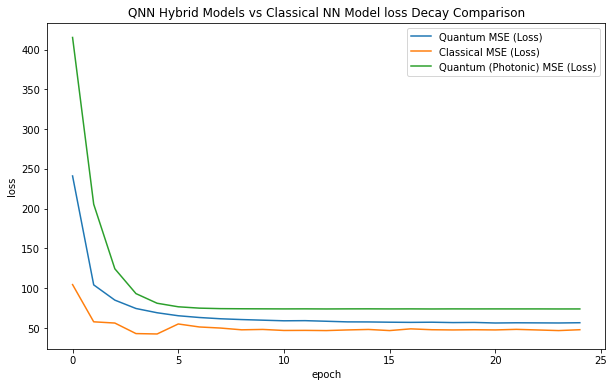

In [ ]:
# Plot QNN Hybrid Model loss
plt.figure(figsize=(10, 6))
plt.plot(quantum_history.history['loss'], label="Quantum MSE (Loss)")
plt.plot(classical_history.history['loss'], label="Classical MSE (Loss)")
plt.plot(quantum_history_photonic.history['loss'], label="Quantum (Photonic) MSE (Loss)")
plt.title('QNN Hybrid Models vs Classical NN Model loss Decay Comparison')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

### Real vs Predicted Price Comparison

Text(0.5, 1.0, 'Real vs Predicted Price Comparison (Quantum Photonic)')

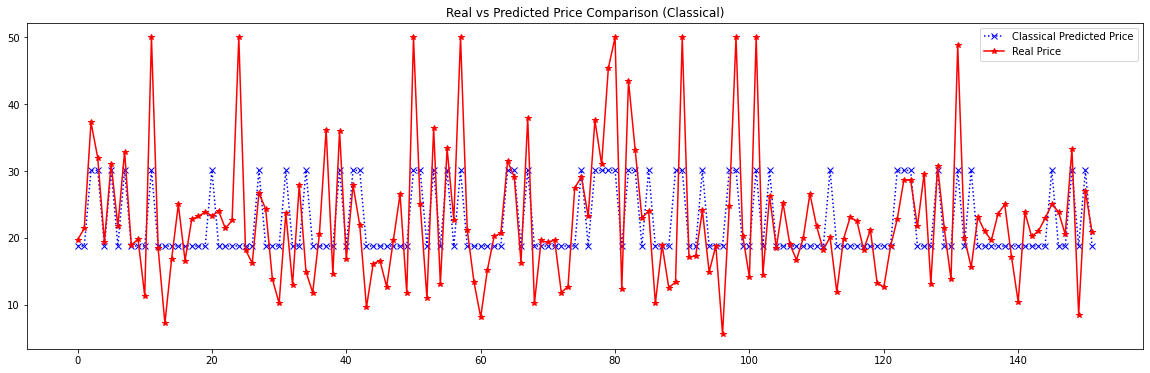

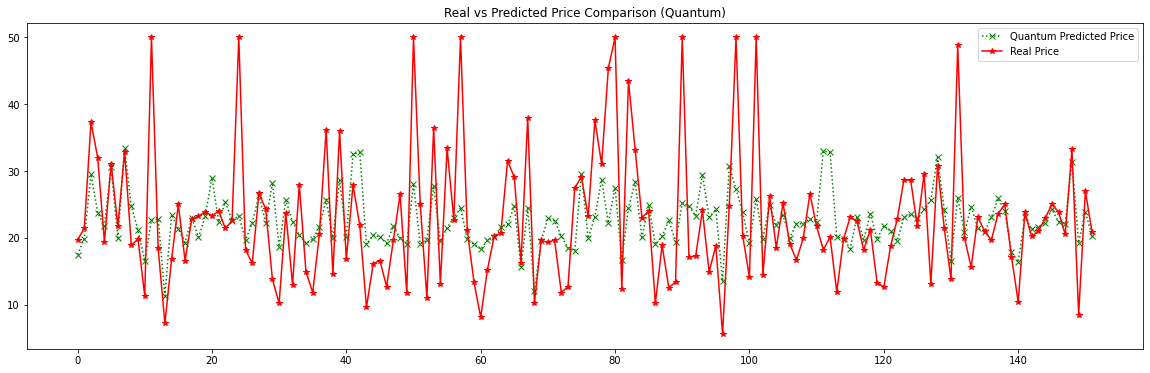

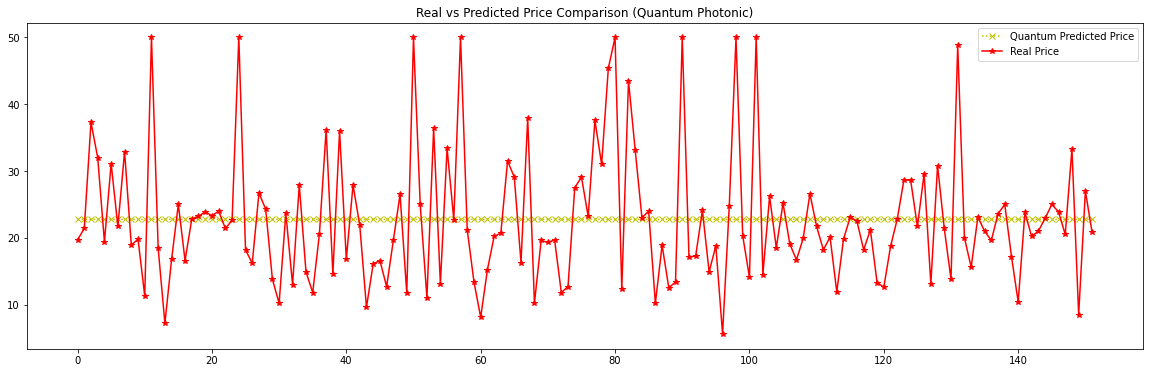

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(y_pred_c, marker="x", linestyle=':', color='b', label="Classical Predicted Price")
plt.plot(y_test, marker='*', linestyle='-', color='r', label ="Real Price")
plt.legend(loc="upper right")
plt.title('Real vs Predicted Price Comparison (Classical)')

plt.figure(figsize=(20, 6))
plt.plot(y_pred_q, marker="x", linestyle=':', color='g', label="Quantum Predicted Price")
plt.plot(y_test, marker='*', linestyle='-', color='r', label ="Real Price")
plt.legend(loc="upper right")
plt.title('Real vs Predicted Price Comparison (Quantum)')

plt.figure(figsize=(20, 6))
plt.plot(y_pred_q_p, marker="x", linestyle=':', color='y', label="Quantum Predicted Price")
plt.plot(y_test, marker='*', linestyle='-', color='r', label ="Real Price")
plt.legend(loc="upper right")
plt.title('Real vs Predicted Price Comparison (Quantum Photonic)')